# Running Llava: a large multi-modal model on Google Colab

Llava is a multi-modal image-text to text model that can be seen as an "open source version of GPT4". It yields to very nice results as we will see in this Google Colab demo.

![image/png](https://cdn-uploads.huggingface.co/production/uploads/62441d1d9fdefb55a0b7d12c/FPshq08TKYD0e-qwPLDVO.png)

The architecutre is a pure decoder-based text model that takes concatenated vision hidden states with text hidden states.

We will leverage QLoRA quantization method and use `pipeline` to run our model.

In [ ]:
!pip install -q -U transformers==4.37.2
!pip install -q bitsandbytes==0.41.3 accelerate==0.25.0

In [ ]:
!pip install transformers --upgrade

Lava-Next-34b

## Load an image

Let's use the image that has been used for Llava demo

And ask the model to describe that image!

In [ ]:
import requests
from PIL import Image

image_url = "https://llava-vl.github.io/static/images/view.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)

# image_url = '/content/sample/test/1/CODE1138 2023-02-07 20-09-16-3.jpg'
# image = Image.open(image_url)

image

## Preparing the quantization config to load the model in 4bit precision

In order to load the model in 4-bit precision, we need to pass a `quantization_config` to our model. Let's do that in the cells below

In [ ]:
import torch
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
#     low_cpu_mem_usage=True,
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

## Load the model using `pipeline`

In [ ]:
import torch
torch.cuda.empty_cache()

We will leverage the `image-to-text` pipeline from transformers !

In [ ]:
from transformers import pipeline

# model_id = "llava-hf/llava-1.5-7b-hf"
# model_id = "llava-hf/llava-1.5-13b-hf"
model_id = "llava-hf/vip-llava-13b-hf"

pipe = pipeline(
    "image-to-text",
    model=model_id,
    model_kwargs={"quantization_config": quantization_config},
)

It is important to prompt the model wth a specific format, which is:
```bash
USER: <image>\n<prompt>\nASSISTANT:
```

In [ ]:
# llava-1.5 prompt
# prompt = "USER: <image>\nWhat are the things I should be cautious about when I visit this place?\nASSISTANT:"
# prompt = 'USER: <image>\nIs there flooding in this image? reply with "0" or "1" only\nASSISTANT:'
prompt = 'USER: <image>\nIs there significant water accumulation such as water-blade, water-bag or flooding? Reply only with "0" or "1", nothing else.\nASSISTANT:'

# vip-llava prompt
# prompt = f'An image classifier to identify flooding in city cameras.\n###Human: <image>\nIs there flooding in this image? reply with "0" or "1" only\n###Assistant:'
# prompt = f'An image classifier to identify flooding in city cameras.\n###USER: <image>\nIs there flooding in this image? reply with with "0" or "1" and provide a probability estimate\n###ASSISTANT:'

# Run the model
max_new_tokens = 2
outputs = pipe(
    image,
    prompt=prompt,
    generate_kwargs={"max_new_tokens": max_new_tokens}
)

print(outputs[0]["generated_text"])

The model has managed to successfully describe the image with accurate result ! We also support other variants of Llava, such as [`bakLlava`](https://huggingface.co/llava-hf/bakLlava-v1-hf) which should be all posted inside the [`llava-hf`](https://huggingface.co/llava-hf) organization on 🤗 Hub

---
## Steps for google colab

#### Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Unzip folder with images

In [ ]:
import zipfile
# file_path = '/content/drive/MyDrive/Flood-Image-Classification/splits/sample.zip'
file_path = '/content/drive/MyDrive/Flood-Image-Classification/splits/balanced-10.zip'
to_file_path = '/content/'
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(to_file_path)

---
## Evaluate multiple images

#### Define class to track loop progress

In [ ]:
from time import time
from IPython.display import clear_output as co

class Progress:
    def __init__(self, total):

        self.total = total
        self.i = -1
        self.start = time()
        self.display()

    def display(self):
        self.i += 1

        done = self.i
        progress = done / self.total * 100
        left = self.total - done
        seconds = time() - self.start
        fps = done / max(seconds, 1e-6)
        minutes = seconds // 60
        seconds = seconds % 60

        minutes = int(minutes)
        progress = int(progress)
        fps = round(fps, 2)
        seconds = round(seconds, 1)

        bar_size = 40
        bar_done = bar_size * done / self.total
        bar_done = int(bar_done)
        bar_left = bar_size - bar_done

        text = f'|{"█" * bar_done}{" " * bar_left}| {done}/{self.total} [{progress}%] in {minutes}:{seconds} ({fps}/s)'
        co(True)
        print(text)

# Example usage
from time import sleep
total = 5
p = Progress(total)
for i in range(total):
    sleep(1)
    p.display()

#### Define function to classify images

In [ ]:
def classify_image(image_path, pipe, prompt, max_new_tokens=5):
    image = Image.open(image_path)
    outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": max_new_tokens})
    label = outputs[0]["generated_text"].lower().split('assistant:')[1]
    label = label.strip()
    if label.isdigit():
        label = int(label)
    elif label in ["Yes", "No"]:
        label = int(label == "Yes")
    return {'label': label}

#### Define functions to evaluate classification output

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report as cr

def custom_cr(y_true, y_hat):
    stats = cr(y_true, y_hat, output_dict=True, zero_division=0)
    return {
        'accuracy': stats['accuracy'],
        'recall_0': stats['0']['recall'],
        'recall_1': stats['1']['recall'],
        'precision_0': stats['0']['precision'],
        'precision_1': stats['1']['precision'],
    }

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

def group_classification_report(y_true, y_hat, codes, sort_by='accuracy', name='TEST', figsize=(4, 8)):

    # Classification report
    print(f'\nClassification Report ({name}):\n')
    print(cr(y_true, y_hat))

    # Classification report per camera
    stats = []
    for code in codes.unique():
        msk = codes == code
        stat = custom_cr(y_true[msk], y_hat[msk])
        stats.append({'code':code, **stat})
    stats = pd.DataFrame(stats)

    plt.figure(figsize=figsize)
    ax = sns.heatmap(stats.set_index('code').sort_values(sort_by, ascending=False), annot=True)
    ax = ax.set(title=f"{name}")
    return

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

def precision_recall_curve_plot(y_true, probs, title="Precision-Recall Curve"):

    precision, recall, thresholds = precision_recall_curve(y_true, probs, pos_label=1)

    plt.plot(thresholds, precision[:-1])
    plt.plot(thresholds, recall[:-1])
    plt.title(title)
    plt.legend(['Precision', 'Recall'])
    plt.xlabel('Confidence')
    return plt.show()

#### Define function to calculate accuracy for subsamples

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def subsample_accuracy_plot(y_true, y_pred, n_samples=500, n_images=250):
    sizes = list(range(1, len(y_true) + 1))
    accs = [accuracy_score(y_true.sample(i, random_state=i), y_pred.sample(i, random_state=i)) for i in sizes]

    plt.figure(figsize=(5, 3.5))
    plt.plot(sizes, accs)
    plt.title('Accuracy vs Sample Size')
    plt.show()

    sizes = range(n_samples)
    accs = [accuracy_score(y_true.sample(n_images, random_state=i), y_pred.sample(n_images, random_state=i)) for i in sizes]

    plt.figure(figsize=(5, 3.5))
    plt.plot(sizes, accs)
    plt.title(f'Accuracy vs Random Samples ({n_images} samples x {n_samples} times)')
    plt.show()

    plt.figure(figsize=(5, 3.5))
    plt.hist(accs)
    plt.title(f'Accuracy Frequency ({n_images} samples x {n_samples} times)')
    plt.show()

#### Load dataset with paths to images

In [ ]:
import pandas as pd

dataset_folder = '/kaggle/input/flood-balanced-100/balanced-100'


df = pd.read_csv(f'{dataset_folder}/images.csv', index_col=0)
df['true_path'] = [f"{dataset_folder}/{row['set']}/{row['flood']}/{row['file_name']}" for idx, row in df.iterrows()]

import os
exists = [os.path.exists(path) for path in df['true_path']]

display(df.head(1))
print('  * All paths exist:', all(exists))

In [ ]:
# llava-1.5 prompt
# prompt = "USER: <image>\nWhat are the things I should be cautious about when I visit this place?\nASSISTANT:"
# prompt = 'USER: <image>\nIs there flooding in this image? reply with "0" or "1" only\nASSISTANT:'
# prompt = 'USER: <image>\nIs there significant water accumulation such as water-blade, water-bag or flooding? Reply only with "0" or "1", nothing else.\nASSISTANT:'
prompt = 'USER: <image><image>\nWhat is the difference between the two images?\nASSISTANT:'

# vip-llava prompt
# prompt = f'An image classifier to identify flooding in city cameras.\n###Human: <image>\nIs there flooding in this image? reply with "0" or "1" only\n###Assistant:'
# prompt = f'An image classifier to identify flooding in city cameras.\n###USER: <image>\nIs there flooding in this image? reply with with "0" or "1" and provide a probability estimate\n###ASSISTANT:'

# Run the model
max_new_tokens = 2
outputs = pipe(
    [image0, image1],
    prompt=prompt,
    genearate_kwargs={"max_new_tokens": max_new_tokens}
)

print(outputs[0]["generated_text"])

#### Build prompt for flood images classification

In [ ]:
base_prompt = 'USER: <image>\nIs there significant water accumulation such as water-blade, water-bag or flooding? Reply only with "0" or "1", nothing else.\nASSISTANT:'

#### Load and classify images progressively

In [ ]:
import os
import json

rs = 12345
pred_path = f'/kaggle/working/models/{model_id}/pred_val.json'
prompt = 'USER: <image>\nIs there significant water accumulation such as water-blade, water-bag or flooding? Reply only with "0" or "1", nothing else.\nASSISTANT:'
data = df[df['set'] == 'val'].copy()

# Shuffle data
df_random = data.sample(len(data), random_state=rs)

# Create folder path
pred_folder = os.path.dirname(pred_path)
if not os.path.exists(pred_folder):
    os.makedirs(pred_folder)
    
# Load existing results
try:
    results = json.load(open(pred_path, 'r'))
except FileNotFoundError:
    results = []

# Start tracking progress
left = len(data) - len(results)
p = Progress(left)

for i, (idx, row) in enumerate(df_random.iterrows()):
    # Only process the next file in the queue
    if i == len(results):
        # Get the image path
        image_path = row['true_path']

        # Classify the image
        data = classify_image(image_path, pipe, prompt)

        # Extract the result
        label = data['label']
        result = {'index': idx, 'label': label}

        # Store the result
        results.append(result)

        # Save the result progressively
        with open(pred_path, 'w') as fw:
            fw.write(json.dumps(results))

        # Display progress
        p.display()


#### Reload and process results

In [ ]:
import json
import pandas as pd

model_id = "llava-hf/vip-llava-13b-hf"
pred_path = f'/kaggle/working/models/{model_id}/pred.json'

pred = json.load(open(pred_path, 'r'))
pred = pd.DataFrame(pred).set_index('index')
pred['code'] = df['code'].loc[pred.index]

# Process result
pred.loc[pred['label'].isin([' 1', ' Yes']), 'label'] = 1
pred.loc[pred['label'].isin([' 0', ' No']), 'label'] = 0
pred['label'] = pred['label'].astype(int)

# Get true and predicted labels
y_true = df['flood'].loc[pred.index].copy()
y_pred = pred['label'].copy()

display(pred.head())

#### Display classification metrics

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix as CM

cm = CM(y_true, y_pred)
plt.figure(figsize=(5, 3.5))
plt.title("Confusion Matrix")
ax = sns.heatmap(cm, annot=True, fmt="")

#### Calculate accuracy for subsamples

In [ ]:
subsample_accuracy_plot(y_true, y_pred, n_samples=500, n_images=250)

#### Evaluate classification for each camera (Test Set)

In [ ]:
codes = pred['code']

group_classification_report(y_true, y_pred, codes, sort_by='accuracy', name='TEST SET', figsize=(4, 8))

#### References
- https://huggingface.co/llava-hf
- https://huggingface.co/tasks/image-to-text

---
### Resultados: llava-hf/vip-llava-13b-hf

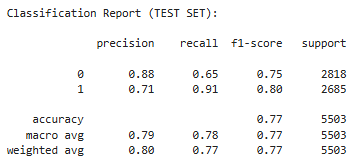

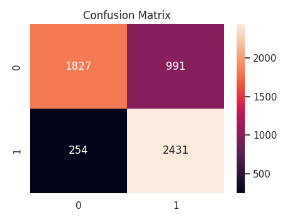

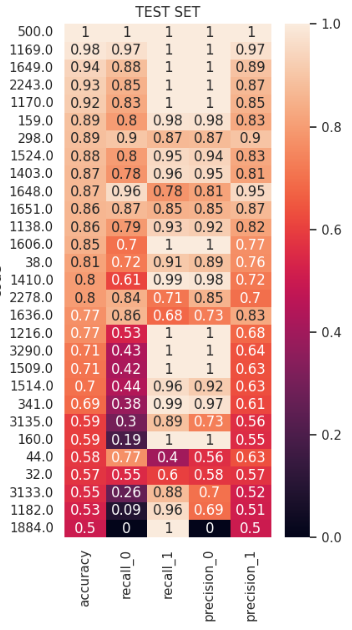

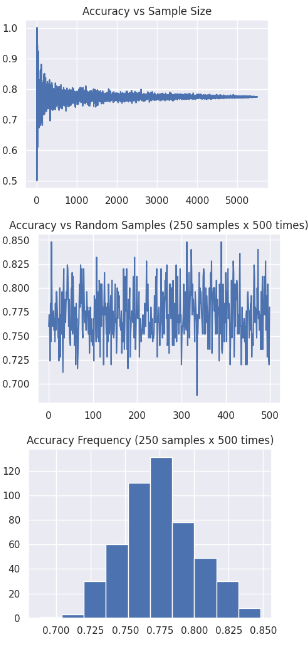